In [4]:
'''importing packages'''
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from skimage import io

## Data Preparation

In [15]:
'''parameters to run model more efficiently'''
IMAGE_SIZE = 128

#this defines if we treat the data upsampled or not

#if upsample, multiplies rotated images and tests on normal initial dataset (separated)
sample_of_choice = "upsample"

#if normal, uses the 40,060 images without further manipulation
# sample_of_choice = "normal"


In [16]:
#define file
meta_pd = pd.read_csv('./HAM10000/HAM10000_metadata.csv')
#sanity check
meta_pd[meta_pd["dx"]=="nv"].count()

lesion_id       6705
image_id        6705
dx              6705
dx_type         6705
age             6660
sex             6705
localization    6705
dtype: int64

In [17]:
meta_pd = meta_pd.sort_values(by = ['image_id'])

In [18]:
meta_pd.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest


In [19]:
def caster(val):
    if val == 'histo':
        return 1
    return 0

In [20]:
raw_labels = meta_pd['dx_type'].map(caster).values.reshape((-1, 1))

In [21]:
meta_pd.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [22]:
'''Extract data from folders'''

def extract_data(folderName):
    num_images = len(
        [name for name in os.listdir(folderName) 
         if os.path.isfile(os.path.join(folderName, name))
        ])
    print("number of images: " + str(num_images))
    data = np.zeros(shape=(num_images,IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.int32) # not sure if int32 is good
    count = 0
    for filename in sorted(os.listdir(folderName)):
        image = io.imread(folderName + '/' + filename)
        data[count] = image
        count = count + 1
    print(count)
    return data    

In [23]:
all_images = extract_data('all_data_128') #change for all_data_128 if want more detailed images
print(all_images.shape)

number of images: 40060
40060
(40060, 128, 128, 3)


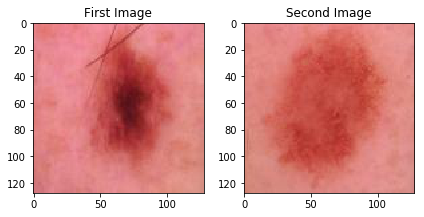

In [24]:
# Heath Check to See if we read the train data properly

fig, axes = plt.subplots(nrows = 1, ncols = 2)

ax = axes.ravel()

ax[0].set_title("First Image")
ax[0].imshow(all_images[0])

ax[1].set_title("Second Image")
ax[1].imshow(all_images[10])

plt.tight_layout()
plt.show()

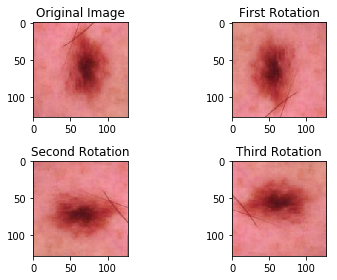

In [25]:
# Heath Check to See if we read the train data properly

fig, axes = plt.subplots(nrows = 2, ncols = 2)

ax = axes.ravel()

ax[0].set_title("Original Image")
ax[0].imshow(all_images[0])

ax[1].set_title("First Rotation")
ax[1].imshow(all_images[10015])

ax[2].set_title("Second Rotation")
ax[2].imshow(all_images[10015*2])

ax[3].set_title("Third Rotation")
ax[3].imshow(all_images[10015*3])



plt.tight_layout()
plt.show()

In [26]:
# get the 4x labels
def four_time_expand(arr):
    return np.concatenate((arr, arr, arr, arr), axis = 0)

In [27]:
labels = four_time_expand(raw_labels)
print(labels.shape)
print(np.sum(labels, axis = 0))

(40060, 1)
[21360]


In [28]:
avg_age = np.floor(np.mean(meta_pd['age'][meta_pd['age'].notnull()]))
meta_pd['age'][meta_pd['age'].isnull()] = avg_age

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
meta_pd['age'][meta_pd['age'].isnull()]

Series([], Name: age, dtype: float64)

In [30]:
# future meta data block
sex = pd.get_dummies(meta_pd['sex']).values.astype(np.float32)
location = pd.get_dummies(meta_pd['localization']).values.astype(np.float32)
age = np.array(meta_pd['age']).reshape((-1, 1))
age = (age - np.mean(age)) / np.std(age)

In [31]:
print(sex.shape)
print(age.shape)
print(location.shape)

(10015, 3)
(10015, 1)
(10015, 15)


In [32]:
raw_meta_input = np.concatenate((sex, age, location), axis = 1)
meta_input = four_time_expand(raw_meta_input)
meta_input.shape

(40060, 19)

In [33]:
all_images.shape

(40060, 128, 128, 3)

In [34]:
# normalize imges
def normalize_image(image):
    """
    Normalize each input image

    Args:
        image: the input image in shape (3,image_H,image_W)
    Returns:
        norimg: the normalized image in the same shape as the input
    """
    norimg = np.zeros(image.shape)
    for color in range(image.shape[2]):
        mean = np.mean(image[color])
        std = np.std(image[color])
        if std == 0:
            std = 1
        norimg[color] = (image[color] - mean) / std
    return norimg

In [35]:
for i in range(all_images.shape[0]):
    all_images[i] = normalize_image(all_images[i])

In [36]:
from sklearn.model_selection import train_test_split # used to shuffle
images_train, images_test, meta_train, meta_test, labels_train, labels_test = train_test_split(all_images, meta_input, labels, test_size = 0.20)

In [37]:
print("data train shape")
print(images_train.shape)
print("labels train shape")
print(labels_train.shape)

print("\n")

print("data test shape")
print(images_test.shape)
print("labels test shape")
print(labels_test.shape)

data train shape
(32048, 128, 128, 3)
labels train shape
(32048, 1)


data test shape
(8012, 128, 128, 3)
labels test shape
(8012, 1)


## Neural Net

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


In [26]:
NUM_CHANNELS = 3 # RGB IMAGE
NUM_LABELS = 1 #should be 7/1/4
BATCH_SIZE = 32
STEPS = (images_train.shape[0] + 1) // BATCH_SIZE
EPOCHS = 10
# IMAGE_SIZE = 28

In [91]:

# The old model
# the shape of the input should be the one image's shape
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu')(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate = 0.5)(x)
predictions = Dense(NUM_LABELS, activation='relu')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
# print(type(model))
model.compile(optimizer=Adam(lr=0.0007), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_6 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               3965440   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [93]:
model.fit(images_train, labels_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.1)

Train on 32448 samples, validate on 3606 samples
Epoch 1/6
32448/32448 [==============================] - 60s 2ms/sample - loss: 0.6136 - acc: 0.7707 - val_loss: 0.4565 - val_acc: 0.8491
Epoch 2/6
32448/32448 [==============================] - 60s 2ms/sample - loss: 0.5805 - acc: 0.7853 - val_loss: 0.4840 - val_acc: 0.8136
Epoch 3/6
32448/32448 [==============================] - 60s 2ms/sample - loss: 0.6025 - acc: 0.7807 - val_loss: 0.5564 - val_acc: 0.7160
Epoch 4/6
32448/32448 [==============================] - 60s 2ms/sample - loss: 0.5711 - acc: 0.7798 - val_loss: 0.5765 - val_acc: 0.8134
Epoch 5/6
32448/32448 [==============================] - 60s 2ms/sample - loss: 0.6139 - acc: 0.7634 - val_loss: 0.4703 - val_acc: 0.8128
Epoch 6/6
32448/32448 [==============================] - 61s 2ms/sample - loss: 0.5474 - acc: 0.7943 - val_loss: 0.4412 - val_acc: 0.8369


In [96]:
predictions = np.where(model.predict(images_test) > 0.5, 1, 0)

In [97]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
print("confusion matric: ")
confusion = confusion_matrix(y_true = labels_test, y_pred = predictions)
print(confusion)
print("reall: ", recall_score(labels_test, predictions))
print("precision: ", precision_score(labels_test, predictions))
print("f1 score: ", f1_score(labels_test, predictions))
test_acc = np.sum(predictions == labels_test) / len(labels_test)
print("test acc: ", test_acc)

confusion matric: 
[[1470  368]
 [ 295 1873]]
reall:  0.863929889298893
precision:  0.8357875948237394
f1 score:  0.8496257654797007
test acc:  0.8344982526210684


## Neural Net with Metadata

In [53]:
import tensorflow.keras as keras

In [54]:
# The model with meta-data
NUM_CHANNELS = 3 # RGB IMAGE
NUM_LABELS = 1 #should be 7/1/4
BATCH_SIZE = 32
STEPS = (images_train.shape[0] + 1) // BATCH_SIZE
EPOCHS = 6 # it seem the best epoch is 3 / 6
# IMAGE_SIZE = 28
NUM_FEATURES = 19

In [55]:
# main input is the image
main_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), name='main_input')
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu')(main_input)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu')(x)
x = Flatten()(x)
# the meta data goes here
auxiliary_input = Input(shape=(NUM_FEATURES,), name='aux_input')
x = keras.layers.concatenate([x, auxiliary_input])
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_LABELS, activation='relu')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=[main_input, auxiliary_input], outputs=predictions)
# model.compile(optimizer=Adam(lr=0.001), 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 126, 126, 32) 896         main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 63, 63, 32)   0           conv2d_282[0][0]                 
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 61, 61, 64)   18496       max_pooling2d_12[0][0]           
__________________________________________________________________________________________________
conv2d_284

In [57]:
model.fit([images_train, meta_train], labels_train, 
          epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.1)

Train on 28843 samples, validate on 3205 samples
Epoch 1/6
 2560/28843 [=>............................] - ETA: 22:36 - loss: 7.5667 - acc: 0.5207


KeyboardInterrupt



In [ ]:
predictions = np.where(model.predict([images_test, meta_test]) > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
print("confusion matric: ")
confusion = confusion_matrix(y_true = labels_test, y_pred = predictions)
print(confusion)
print("reall: ", recall_score(labels_test, predictions))
print("precision: ", precision_score(labels_test, predictions))
print("f1 score: ", f1_score(labels_test, predictions))
test_acc = np.sum(predictions == labels_test) / len(labels_test)
print("test acc: ", test_acc)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 5, solver='lbfgs', max_iter = 500)

In [32]:
images_train_flatten = images_train.reshape((images_train.shape[0], -1))
images_test_flatten = images_test.reshape((images_test.shape[0], -1))
labels_train_flatten = labels_train.reshape(-1)
labels_test_flatten = labels_test.reshape(-1)

In [34]:
LRmodel.fit(images_train_flatten, labels_train_flatten)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [116]:
predictions = LRmodel.predict(images_test_flatten)

In [120]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
print("confusion matric: ")
confusion = confusion_matrix(y_true = labels_test_flatten, y_pred = predictions)
print(confusion)
print("reall: ", recall_score(labels_test, predictions))
print("precision: ", precision_score(labels_test, predictions))
print("f1 score: ", f1_score(labels_test, predictions))
test_acc = np.sum(predictions == labels_test_flatten) / len(labels_test_flatten)
print("test acc: ", test_acc)

confusion matric: 
[[1450  388]
 [ 319 1849]]
reall:  0.852859778597786
precision:  0.8265534197586053
f1 score:  0.83950056753689
test acc:  0.8235147279081378


## LR with Metadata

In [54]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 5, solver='lbfgs', max_iter = 500)

In [55]:
images_train_flatten = images_train.reshape((images_train.shape[0], -1))
images_test_flatten = images_test.reshape((images_test.shape[0], -1))
labels_train_flatten = labels_train.reshape(-1)
labels_test_flatten = labels_test.reshape(-1)

In [59]:
data_train_flatten = np.concatenate([images_train_flatten, meta_train],axis = 1)
data_test_flatten = np.concatenate([images_test_flatten, meta_test],axis = 1)

In [60]:
data_train_flatten.shape

(32048, 2371)

In [61]:
LRmodel.fit(data_train_flatten, labels_train_flatten)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
predictions = LRmodel.predict(data_test_flatten)

In [63]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
print("confusion matric: ")
confusion = confusion_matrix(y_true = labels_test_flatten, y_pred = predictions)
print(confusion)
print("reall: ", recall_score(labels_test, predictions))
print("precision: ", precision_score(labels_test, predictions))
print("f1 score: ", f1_score(labels_test, predictions))
test_acc = np.sum(predictions == labels_test_flatten) / len(labels_test_flatten)
print("test acc: ", test_acc)

confusion matric: 
[[3174  563]
 [ 543 3732]]
reall:  0.8729824561403509
precision:  0.8689173457508731
f1 score:  0.8709451575262545
test acc:  0.8619570644033949


## Advanced Model: Inception V3 (not applicable for 28x28 images)

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3

In [39]:
NUM_CHANNELS = 3 # RGB IMAGE
NUM_LABELS = 1 #should be 7/1/4
BATCH_SIZE = 32
STEPS = (images_train.shape[0] + 1) // BATCH_SIZE
EPOCHS = 10
# IMAGE_SIZE = 128

In [48]:
# The old model
# the shape of the input should be the one image's shape
model = Sequential()
model.add(InceptionV3(include_top=False, weights='imagenet', input_tensor=None, 
                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), pooling='max'))
model.add(Dense(NUM_LABELS))
# print(type(model))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [52]:
model.fit(images_train, labels_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split = 0.1)

Train on 28843 samples, validate on 3205 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
 5472/28843 [====>.........................] - ETA: 30:04 - loss: 7.2619 - acc: 0.5422

KeyboardInterrupt: 

In [42]:
predictions = np.where(model.predict(images_test) > 0.5, 1, 0)

In [43]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
print("confusion matric: ")
confusion = confusion_matrix(y_true = labels_test, y_pred = predictions)
print(confusion)
print("reall: ", recall_score(labels_test, predictions))
print("precision: ", precision_score(labels_test, predictions))
print("f1 score: ", f1_score(labels_test, predictions))
test_acc = np.sum(predictions == labels_test) / len(labels_test)
print("test acc: ", test_acc)

confusion matric: 


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [45]:
predictions.shape

(8012, 2048)

## Write the Predictions

In [41]:
all_predictions = LRmodel.predict(all_images.reshape((all_images.shape[0], -1)))

In [42]:
labels.shape

(40060, 1)

In [47]:
pd.Series(all_predictions)

0        0
1        0
2        0
3        0
4        1
5        0
6        1
7        1
8        1
9        1
10       0
11       1
12       0
13       1
14       0
15       0
16       0
17       1
18       1
19       0
20       0
21       0
22       1
23       1
24       1
25       0
26       1
27       1
28       0
29       0
        ..
40030    0
40031    1
40032    1
40033    1
40034    1
40035    1
40036    1
40037    1
40038    1
40039    1
40040    1
40041    1
40042    1
40043    1
40044    0
40045    1
40046    1
40047    1
40048    1
40049    1
40050    1
40051    1
40052    1
40053    1
40054    1
40055    1
40056    1
40057    1
40058    1
40059    1
Length: 40060, dtype: int64

In [57]:
rslt = pd.DataFrame()
rslt['image_id'] = meta_pd['image_id']
rslt['predictions'] = pd.Series(all_predictions)
rslt['true_label'] = pd.Series(labels.reshape(-1))

In [59]:
rslt.head(5)

,image_id,predictions,true_label
4349,ISIC_0024306,1,1
4263,ISIC_0024307,0,0
4217,ISIC_0024308,0,0
3587,ISIC_0024309,1,1
1451,ISIC_0024310,0,0


In [60]:
rslt.to_csv("28-LR-all-predictions", index = False)

In [61]:
rslt_wrong = rslt[rslt['predictions'] != rslt['true_label']]

In [63]:
rslt_wrong.to_csv("28-LR-all-wrong-predictions", index = False)